In [85]:
library(Seurat)
library(ggplot2)
library(RColorBrewer)
library(patchwork)
library(ArchR)
library(viridis)
library(DoubletFinder)
library(tidyverse)
library(harmony)
library(repr)

Warning message:
"package 'repr' was built under R version 4.1.3"


In [86]:
options(repr.plot.width = 15, repr.plot.height = 10)  # width and height in inches
set.seed(1)

seurat_standard_normalize_and_scale <- function(seurat_proj, cluster, cluster_resolution,
                                                harmonize=F,
                                                harmony_args=list(group.by.vars="orig.ident",
                                                                  theta=2)){
  
  seurat_proj <- NormalizeData(seurat_proj, normalization.method = "LogNormalize", scale.factor = 10000)
  seurat_proj <- FindVariableFeatures(seurat_proj, selection.method = "vst", nfeatures = 2000)
  all.genes <- rownames(seurat_proj)
  seurat_proj <- ScaleData(seurat_proj)
#   seurat_proj <- ScaleData(seurat_proj, features = all.genes)
  seurat_proj <- RunPCA(seurat_proj, features = VariableFeatures(object = seurat_proj))
  
  if (harmonize) {
      seurat_proj <- RunHarmony(seurat_proj, group.by.vars=harmony_args$group.by.vars,
                                           theta=harmony_args$theta) 
      seurat_proj <- RunUMAP(seurat_proj, reduction="harmony", dims = 1:20)
  } else {
      seurat_proj <- RunUMAP(seurat_proj, dims = 1:20)
  }
    
    
  if (cluster) {
    seurat_proj <- FindNeighbors(seurat_proj, dims = 1:20)
    seurat_proj <- FindClusters(seurat_proj, resolution = cluster_resolution)
  }

  return(seurat_proj)
}

make_seurat_object_and_doublet_removal <- function(data_directory, project_name){
  # function for basic seurat based qc and doubletfinder based doublet removal
  colon.data <- Read10X(data.dir = data_directory)
  currentSample <- CreateSeuratObject(counts = colon.data, project = project_name, 
                                      min.cells = 3, min.features = 40)
  currentSample[["percent.mt"]] <- PercentageFeatureSet(currentSample, pattern = "^MT-")
  
  # qc plot-pre filtering
  pdf(paste0("reproduce_greenleaf_results/qc_plots_", project_name, "_prefiltered.pdf"))
  print(VlnPlot(currentSample, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
                ncol = 3, pt.size = 0.05))
  dev.off()
  pdf(paste0("reproduce_greenleaf_results/qc_plots_", 
             project_name, "_prefiltered_no_points.pdf"))
  print(VlnPlot(currentSample, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
                ncol = 3, pt.size = 0))
  dev.off()
  
  # filter everything to 400 unique genes/cell
  currentSample <- subset(currentSample, subset = nFeature_RNA > 400 & nFeature_RNA < 4000)
  
  # Normalize and make UMAP
  currentSample <- seurat_standard_normalize_and_scale(currentSample, FALSE)
  
  # Run doublet finder
  nExp_poi <- round(0.08*length(currentSample@meta.data$orig.ident)*
                    length(currentSample@meta.data$orig.ident)/10000)  ## Assuming 7.5% doublet formation rate - tailor for your dataset
  seu_colon <- doubletFinder_v3(currentSample, PCs = 1:20, pN = 0.25, pK = 0.09, 
                                nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
  print(head(seu_colon@meta.data))
  
  # rename columns
  seu_colon$doublet.class <- seu_colon[[paste0("DF.classifications_0.25_0.09_",nExp_poi)]]
  seu_colon[[paste0("DF.classifications_0.25_0.09_",nExp_poi)]] <- NULL
  pann <- grep(pattern="^pANN", x=names(seu_colon@meta.data), value=TRUE)
  seu_colon$pANN <- seu_colon[[pann]]
  seu_colon[[pann]] <- NULL
  
  # plot pre and post doublet finder results
  pdf(paste0("reproduce_greenleaf_results/UMAP_pre_double_removal", project_name, ".pdf"))
  print(DimPlot(seu_colon, reduction = "umap", group.by = "doublet.class", 
                cols = c("#D51F26", "#272E6A")))
  dev.off()
  seu_colon <- subset(seu_colon, subset = doublet.class != "Doublet")
  pdf(paste0("reproduce_greenleaf_results/UMAP_post_double_removal", project_name, ".pdf"))
  print(DimPlot(seu_colon, reduction = "umap", cols = c("#D51F26")))
  dev.off()
  
  # Remove extra stuff and return filtered Seurat object
  seu_colon <- DietSeurat(seu_colon, counts=TRUE, data=TRUE, scale.data=FALSE, assays="RNA")
  return(seu_colon)
}

seurat_qc_plots <- function(colon, sample_name){
  # Make some basic qc plots
  pdf(paste0("seurat_nFeature_plots_", 
             sample_name, ".pdf"), width = 40, height = 15)
  print(VlnPlot(colon, features = c("nFeature_RNA"), ncol = 1, pt.size = 0.2))
  dev.off()
  
  pdf(paste0("seurat_nCount_plots_", sample_name, ".pdf"), 
      width = 40, height = 15)
  print(VlnPlot(colon, features = c("nCount_RNA"), ncol = 1, pt.size = 0.2))
  dev.off()
  
  pdf(paste0("seurat_pMT_plots_", sample_name, ".pdf"), 
      width = 40, height = 15)
  print(VlnPlot(colon, features = c("percent.mt"), ncol = 1, pt.size = 0.2))
  dev.off()
}

subset_proj <- function(proj, general_cell_type, disease_states=list()) {
    subset_idx = df_seurat[["DiseaseState"]] %in% disease_states & 
                 !is.na(df_seurat[["general_cell_type"]]) &
                 df_seurat[["general_cell_type"]] == general_cell_type 
    proj_subset = subset(proj, cells = colnames(proj)[subset_idx])
    return(proj_subset)
}

plot_gene_markers <- function(seurat_proj) {
    features = list("Metaplasia" = metaplasia, "Fetal" = fetal, "stem_and_wnt" = stem_and_wnt)
    
    for (feature_set_name in names(features)) {
        feature_set = features[feature_set_name]
        seurat_proj = AddModuleScore(seurat_proj, features = feature_set, name=feature_set_name)
        name_for_seurat = paste0(feature_set_name, "1")
        plot = FeaturePlot(object = seurat_proj, features = name_for_seurat) +
                    scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")),
                                           limits = c(-max(abs(seurat_proj[[name_for_seurat]])), 
                                                      max(abs(seurat_proj[[name_for_seurat]]))))
        print(plot)

    }
    cc_genes = readLines("/ahg/regevdata/projects/ICA_Lung/Bruno/gene_sets/regev_lab_cell_cycle_genes.txt")
    s_genes = cc_genes[1:43]
    g2m_genes = cc_genes[44:97]

    seurat_proj = CellCycleScoring(object = seurat_proj, 
                                   s.features = s_genes, 
                                   g2m.features = g2m_genes, 
                                   set.ident = TRUE)
    seurat_proj$cc_score = seurat_proj$S.Score + seurat_proj$G2M.Score

    plot = FeaturePlot(object = seurat_proj, features = 'cc_score') +
                scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")),
                                       limits = c(-max(abs(seurat_proj$cc_score)),
                                                  max(abs(seurat_proj$cc_score))))
    print(plot)
    
}

# Run once

In [3]:
# Define variables
sample_name <- "all_samples"
individual_qc_and_dublet_plot_location <- "/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis/reproduce_greenleaf_results/initial_clustering/doublet_analysis/"
analysis_parent_folder <- "/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis/reproduce_greenleaf_results/"
setwd(analysis_parent_folder)

In [4]:
# Define sets and locations of files for initial processing
scRNA_data_path <- "/broad/hptmp/bgiotti/BingRen_scATAC_atlas/data/scRNAseq/greenleaf_colon"
scRNA_set_names <- c("all_samples_s12a", "all_samples_s12b", "all_samples_s5", 
                     "all_samples_s6", "all_samples_s7", "all_samples_s8", 
                     "all_samples_s3", "all_samples_s4", "all_samples_s9", 
                     "all_samples_s10", "all_samples_s11")
scRNA_sets <- list(c("F007","A014-C-201","A002-C-010","A001-C-207","A001-C-124"), 
                   c("B004-A-204", "B004-A-104", "A002-C-106", "A001-C-223", "A002-C-204", 
                     "A014-C-111"),
                   c("A015-C-203","A015-C-204","A014-C-040","A002-C-201","A002-C-203"), 
                   c("B001-A-301","B001-A-401","A015-C-008","A015-C-208","A014-C-114",
                     "A014-C-043","A001-C-202", "A001-C-119"),
                   c("A001-C-108","A002-C-021","A002-C-212","A002-C-205","A014-C-101",
                     "A014-C-108", "A001-C-104"),
                   c("A015-C-005","A015-C-006","A015-C-106","A002-C-114","A015-C-104",
                     "A015-C-202"), 
                   c("A001-C-014","A001-C-023","A002-C-016","A002-C-024","A014-C-001",
                     "A014-C-054","A015-C-002","A015-C-010"),
                   c("A015-C-109","B004-A-004","A002-C-121-R0", "A002-C-010-R0"), 
                   c("A001-C-007", "A001-C-203", "A002-C-116", "A002-C-121", "A008-E-008", 
                     "A008-E-015", "A010-E-018", "A010-E-023", "A014-C-008", "A014-C-052"),
                   c("A015-C-001", "A018-E-013", "A018-E-020", "B001-A-406", "B001-A-501", 
                     "B004-A-008", "F034", "F072B", "F091", "A022-E-022"),
                   c("CRC1_8810", "CRC2_15564", "CRC3_11773")) 

In [9]:
# 1) Create seurat objects for individual 10x runs, run doblet finder and filter most likely doublets, merge into a seurat object containing all samples
if (1 %in% execute_steps) {
  setwd(individual_qc_and_dublet_plot_location)
  for (j in 1:length(scRNA_set_names)){
    samples <- scRNA_sets[[j]]
    data_directory <- paste(scRNA_data_path, scRNA_set_names[j], samples[1], sep="/")
    sample1 <- make_seurat_object_and_doublet_removal(data_directory, samples[1])
    seu_list <- c()
    for (i in 2:length(samples)){
      data_directory <- paste(scRNA_data_path, scRNA_set_names[j], samples[i], sep="/")
      seu_list <- c(seu_list, make_seurat_object_and_doublet_removal(data_directory, 
                                                                     samples[i]))
    }
    current_merge <- merge(sample1, y = seu_list, add.cell.ids = samples, 
                           project = scRNA_set_names[j])
    if (j==1){
      colon <- current_merge
    } else if (j>1){
      colon <- merge(colon, y = current_merge, project = "full_colon_project")
    }
  }
  setwd("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis/reproduce_greenleaf_results")
  colon[["percent.mt"]] <- PercentageFeatureSet(colon, pattern = "^MT-")
  saveRDS(colon, "initial_full_colon_proj_seurat.rds")
} else if (2 %in% execute_steps) {
  # if 1 is not a step, but 2 is then you need to load the initial object
  setwd(analysis_parent_folder)
  colon <- readRDS("initial_full_colon_proj_seurat.rds")
  # clean up if necessary:
  pann <- grep(pattern="^pANN", x=names(colon@meta.data), value=TRUE)
  for (i in pann){
    colon[[i]] <- NULL
  }
  pann <- grep(pattern="^DF.classification", x=names(colon@meta.data), value=TRUE)
  for (i in pann){
    colon[[i]] <- NULL
  }
}

In [120]:
# 2) QC
if (2 %in% execute_steps){
  # create and set working directory to save qc plots
  if (!dir.exists(paste0(analysis_parent_folder, "all_samples_qc_plots"))){
    dir.create(paste0(analysis_parent_folder, "all_samples_qc_plots"))
  }
  setwd(paste0(analysis_parent_folder, "all_samples_qc_plots"))
  
  # make the standard seurat qc plots
  seurat_qc_plots(colon, sample_name)
  
  # Now subset the project (if not done already)
  colon <- subset(colon, subset = nFeature_RNA > 400 & nFeature_RNA < 4000 & percent.mt < 5 & nCount_RNA < 10000)
  
  # leave the qc directory
  setwd(analysis_parent_folder)
}

In [ ]:
# 3) Add metadata
metadata <- read.table(path_to_metadata, header = TRUE, sep = ",", stringsAsFactors=FALSE)

# remove atac column
metadata <- metadata[,colnames(metadata)[2:26]]
colnames(metadata) <- c("Sample", colnames(metadata)[2:25])
metadata <- metadata[metadata$Sample != "",]

meta_data_types <- colnames(metadata)
for (i in 2:length(meta_data_types)){
identities <- colon[['orig.ident']]
    for (j in 1:length(metadata$Sample)){
      identities[identities==metadata$Sample[j]] <- metadata[j,meta_data_types[i]]
    }
    colon <- AddMetaData(colon, identities$orig.ident, col.name = meta_data_types[i])
}

In [42]:
epithelial = read.table("../data/metadata/greenleaf_colon_epithelial_celltypes_rna.tsv", header=1)
epithelial["general_cell_type"] = "epithelial"
stromal = read.table("../data/metadata/greenleaf_colon_stromal_celltypes_rna.tsv", header=1)
stromal["general_cell_type"] = "stromal"
immune = read.table("../data/metadata/greenleaf_colon_immune_celltypes_rna.tsv", header=1)
immune["general_cell_type"] = "immune"
df_metadata = rbind(epithelial, stromal, immune)
df_metadata["Cell"] = paste0(df_metadata[["Cell"]], "-1")

In [47]:
df_seurat = colon@meta.data %>% 
             rownames_to_column(var = "Cell") %>%
             left_join(df_metadata) %>% 
             column_to_rownames("Cell")

Joining with `by = join_by(Cell, Donor)`


In [54]:
colon@meta.data = df_seurat

In [64]:
colon = write_rds(colon, "reproduce_greenleaf_results/initial_full_colon_proj_seurat.rds")

# Analysis

In [65]:
setwd("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis")
colon = read_rds("reproduce_greenleaf_results/initial_full_colon_proj_seurat.rds")

In [70]:
fetal = c("MDK,ELF3,MSLN,RAB15,CXCL16,ADAM9,HES4,HES1,AQP5,ABHD4,AHNAK,AK1,AKR1B10,ANXA1,ANXA3,BMP8B,BOK,CD55,CLIC3,CRIP2,EPS8L1,DAPK1,DCXR,ECM1,FOSL1,GJB3,GSN,HSPB1,HYAL1,IL1RN,ITGB4,KIFC3,LMNA,PHLDA2,PHLDA3,PDLIM7,P2RY2,PDZK1IP1,PLAUR,PRSS22,CAVIN3,PLCD3,PSCA,RHOD,S100A11,S100A14,S100A16,S100A4,SERPINB5,SLC45A3,TACSTD2,TIMP2,TTC9,VAMP5,VNN1,VSIG1,WWC2")
stem_and_wnt = c("CLDN2,CD44,AXIN2,RNF43,TGFBI,EPHB2,TEAD2,CDX2,LGR5,OLFM4,ASCL2")
metaplasia = c("MSLN,AQP5,TACSTD2,FSCN1,TFF2,ANXA1,ANXA10,REG4,MUC17,S100P,GSDMB,GSDMD,IL18,RELB,MDK,AHR,PDX1")
metaplasia = unlist(strsplit(metaplasia, ","))
fetal = unlist(strsplit(fetal, ","))
stem_and_wnt = unlist(strsplit(stem_and_wnt, ","))
path_to_metadata <- "/broad/hptmp/bgiotti/BingRen_scATAC_atlas/data/metadata/hubmap_htan_metadata_atac_and_rna_final.csv"

# epithelial, no cancer

In [103]:
normal_and_polyp = subset_proj(colon, general_cell_type = "epithelial", 
                         disease_states = c("Normal", "Unaffected", "Polyp"))

In [ ]:
normal_and_polyp = seurat_standard_normalize_and_scale(normal_and_polyp, FALSE, 0.1, harmonize=TRUE)

Warning message:
"The following arguments are not used: nselect"
Centering and scaling data matrix

PC_ 1 
Positive:  PCSK5, PDE3A, MS4A12, HHLA2, PAG1, SCNN1B, TRPM6, GCNT3, GDA, FKBP5 
	   PLAC8, CEACAM1, MICAL2, MXI1, CLIC5, DHRS9, SLC17A4, TMIGD1, CLCA4, EPB41L3 
	   C1orf21, UGP2, PDE9A, PTPRR, MAST2, PLPP1, NEAT1, LRRC1, PIP5K1B, PRSS12 
Negative:  SLC12A2, L1TD1, SOX4, OLFM4, CEMIP, NKD1, CENPF, MKI67, DACH1, MTRNR2L12 
	   MYRIP, GRIN2B, CLCA1, LGR5, NEBL, SNTB1, TOP2A, APOLD1, XACT, CENPE 
	   ASPM, CADPS, SMOC2, KCNH8, ITGA9, ZNRF3, APCDD1, KCTD16, KIF20B, LINC00854 
PC_ 2 
Positive:  SLC26A3, PTPRR, CLCA4, CEACAM1, DST, MS4A12, SLC9A3, GDA, HDAC9, SLCO2A1 
	   TRIM31, TMIGD1, SLC30A10, EMP1, GCNT3, SLC17A4, SGK1, PLAC8, ABCG2, SMIM5 
	   DHRS9, SLC20A1, SLC15A1, AOAH, MTRNR2L12, PLAUR, MGAM2, SAMD9, KRT20, TRANK1 
Negative:  RBFOX1, FOXP2, IMMP2L, MECOM, FHIT, ATP2C2, EFNA5, SATB2, KAZN, NEO1 
	   CDK6, EDIL3, CACNB2, PRKAG2, NAALADL2, BRINP3, SORBS2, LINC01876, CNTN4, ARHGA

In [ ]:
write_rds(normal_and_polyp, "reproduce_greenleaf_results/harmonized_normal_and_polyp.rds")

In [ ]:
# pdf(paste0("./UMAP_samples_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
p = DimPlot(normal_and_polyp, reduction = "umap", group.by = "CellType", 
            cols = paletteDiscrete(values = unique(normal_and_polyp@meta.data$CellType), set = "stallion", 
                                   reverse = FALSE))
print(p)
# dev.off()

In [ ]:
# pdf(paste0("./UMAP_donor_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
print(DimPlot(normal_and_polyp, reduction = "umap", group.by = "orig.ident", cols = paletteDiscrete(values = 
                    unique(normal_and_polyp@meta.data$orig.ident), set = "stallion", reverse = FALSE)))
# dev.off()

In [ ]:
plot_gene_markers(normal_and_polyp)

# Normal only

In [ ]:
normal = subset_proj(colon, general_cell_type = "epithelial", 
                         disease_states = c("Normal", "Unaffected"))

In [ ]:
normal = seurat_standard_normalize_and_scale(normal, FALSE, 0.1, harmonize=TRUE)

In [ ]:
write_rds(normal, "reproduce_greenleaf_results/harmonized_normal.rds")

In [ ]:
# pdf(paste0("./UMAP_samples_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
p = DimPlot(normal, reduction = "umap", group.by = "CellType", 
            cols = paletteDiscrete(values = unique(normal@meta.data$CellType), set = "stallion", 
                                   reverse = FALSE))
print(p)
# dev.off()

In [ ]:
# pdf(paste0("./UMAP_donor_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
print(DimPlot(normal, reduction = "umap", group.by = "orig.ident", cols = paletteDiscrete(values = 
                    unique(normal@meta.data$orig.ident), set = "stallion", reverse = FALSE)))
# dev.off()

In [ ]:
plot_gene_markers(polyp_proj)

# Polyp only

In [74]:
polyp_proj = subset_proj(colon, general_cell_type = "epithelial", disease_states = c("Polyp"))

In [81]:
polyp_proj = seurat_standard_normalize_and_scale(polyp_proj, FALSE, 0.1, harmonize=TRUE)

Warning message:
"The following arguments are not used: nselect"
Centering and scaling data matrix

PC_ 1 
Positive:  PCSK5, TRPM6, MS4A12, PAG1, PDE3A, HHLA2, MICAL2, PIP5K1B, BTNL8, THRB 
	   GDA, GCNT3, LARGE1, EXT1, C1orf21, PTPRR, CEACAM7, LGALS3, MYLK, PLAC8 
	   PDE8A, SLC17A4, KRT20, NR5A2, NEAT1, TCF7L2, TMEM45B, MYO1D, USP53, SLC4A4 
Negative:  L1TD1, SOX4, MTRNR2L12, CENPF, MKI67, SLC12A2, NKD1, TOP2A, CENPE, ASPM 
	   SMOC2, CEMIP, AC078993.1, CLCA1, OLFM4, MYRIP, DLGAP5, KIF20B, XACT, TPX2 
	   KIF15, NUSAP1, GTSE1, NUPR1, APOLD1, IQGAP3, RETNLB, APCDD1, ADAMTSL2, LINC01632 
PC_ 2 
Positive:  DACH1, IMMP2L, SLC12A2, OLFM4, GMDS, CACNB2, SAMD5, CHRM3, ZBTB20, GPHN 
	   FHIT, CDK6, ZNRF3, GRIN2B, KANK1, STXBP6, PTPRK, AL033504.1, MECOM, DLEU2 
	   POU6F2, ARID5B, C9orf3, RAD51B, TMTC2, PTPRG, NAALADL2, MAML3, LINC01572, GRIP1 
Negative:  SLC26A3, MS4A12, SLC9A3, CDHR5, TRPM6, SCNN1B, CLCA4, SLC26A2, TMIGD1, PTPRR 
	   GCNT3, AHNAK, SLC20A1, MYLK, HHLA2, CEACAM7, CA4, HSD17B2

In [102]:
write_rds(polyp_proj, "reproduce_greenleaf_results/harmonized_polyp_only.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



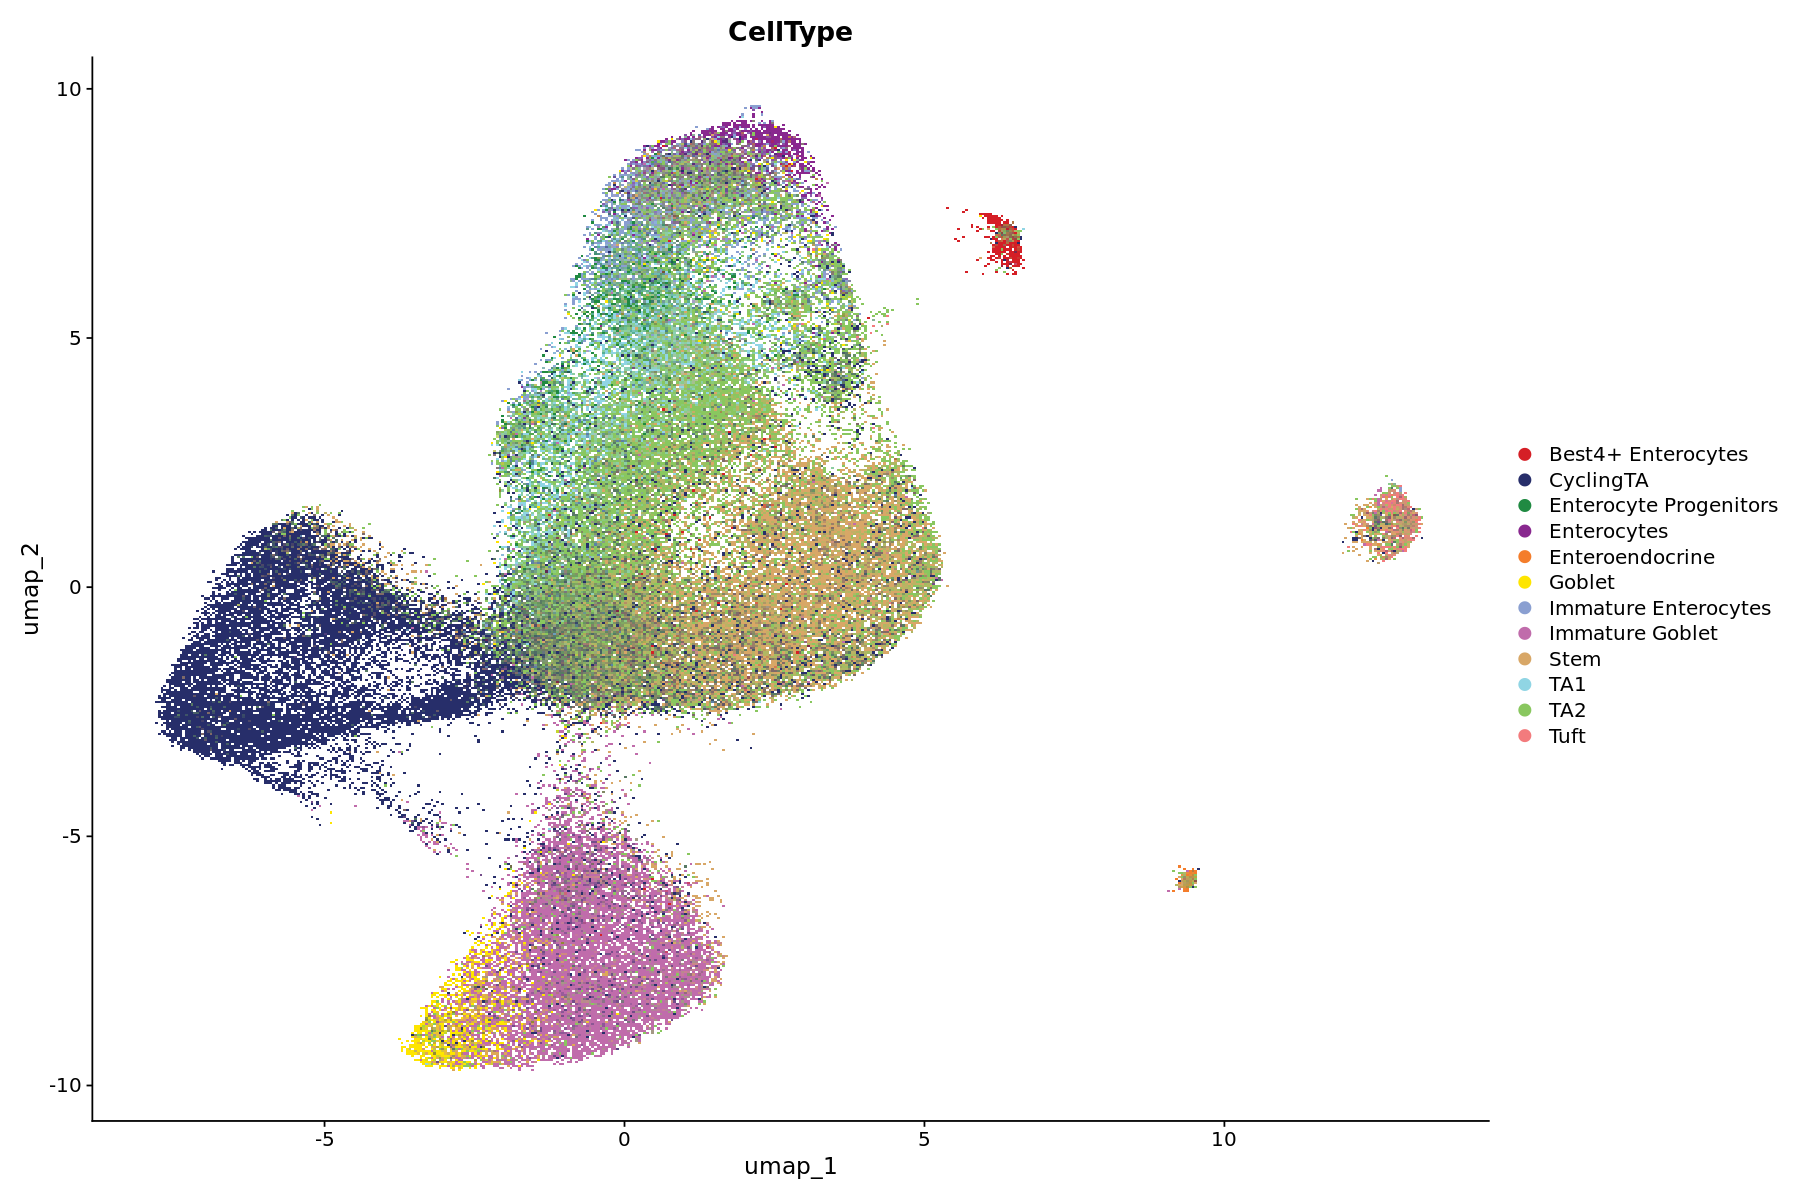

In [87]:
# pdf(paste0("./UMAP_samples_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
p = DimPlot(polyp_proj, reduction = "umap", group.by = "CellType", 
            cols = paletteDiscrete(values = unique(polyp_proj@meta.data$CellType), set = "stallion", 
                                   reverse = FALSE))
print(p)
# dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Length of unique values greater than palette, interpolating..



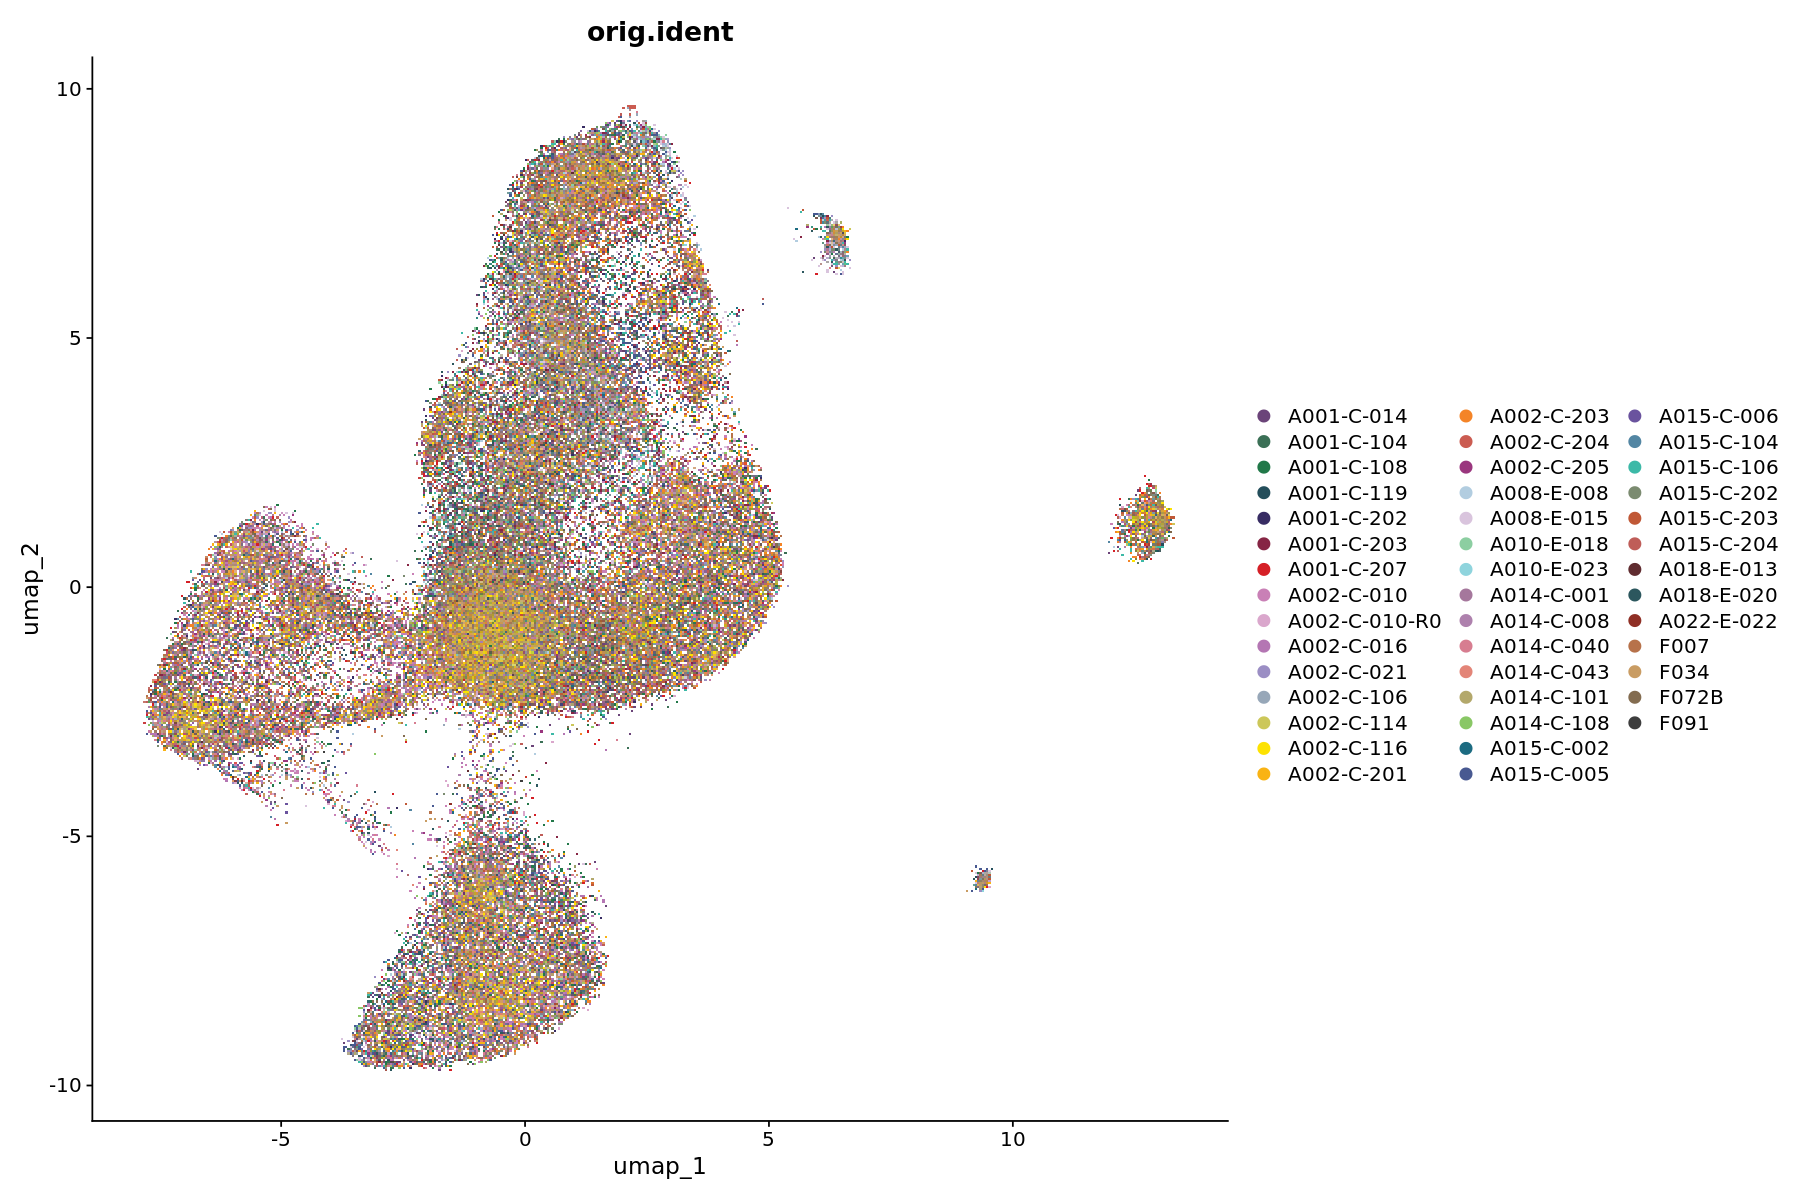

In [95]:
# pdf(paste0("./UMAP_donor_epithelial_polyp_harmony.pdf"), width = 12, onefile=F)
print(DimPlot(polyp_proj, reduction = "umap", group.by = "orig.ident", cols = paletteDiscrete(values = 
                    unique(polyp_proj@meta.data$orig.ident), set = "stallion", reverse = FALSE)))
# dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


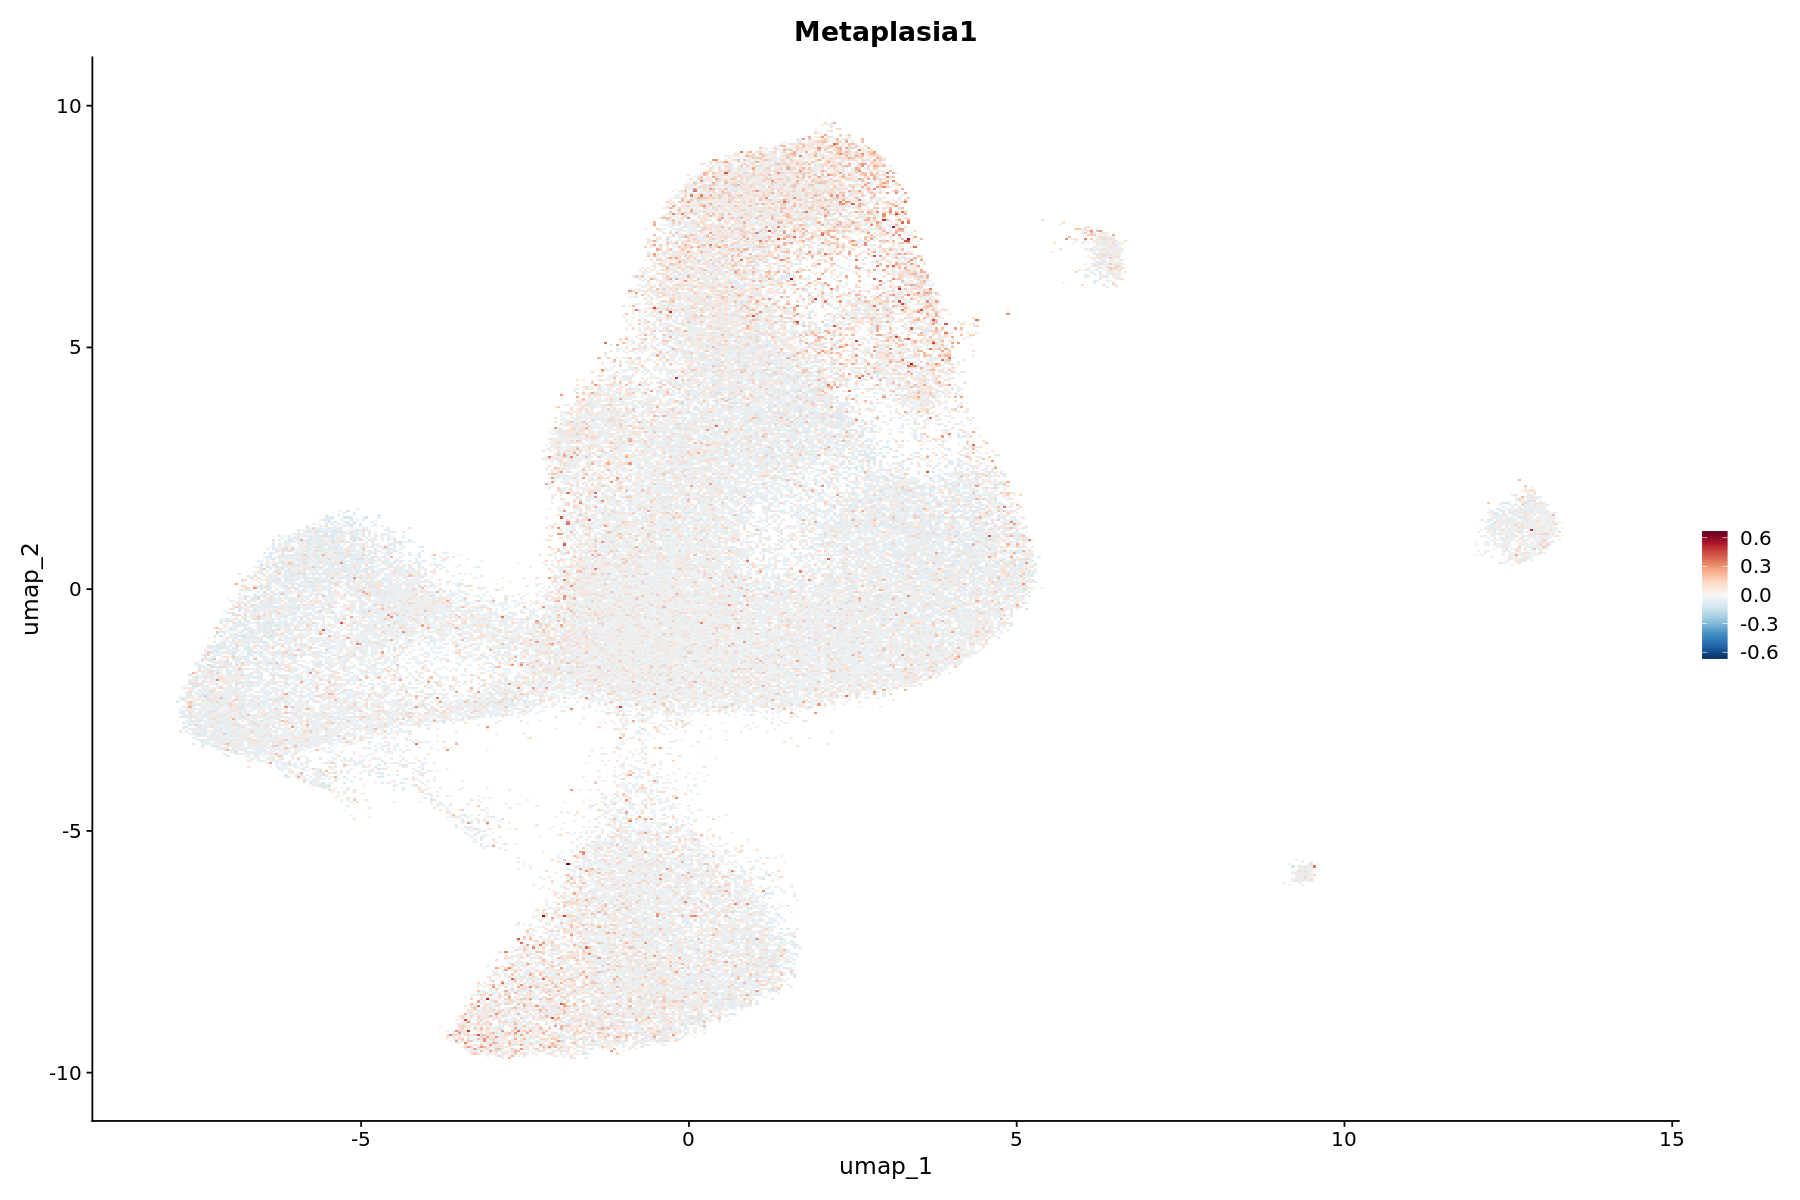

Warning message:
"The following features are not present in the object: FEN1, MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


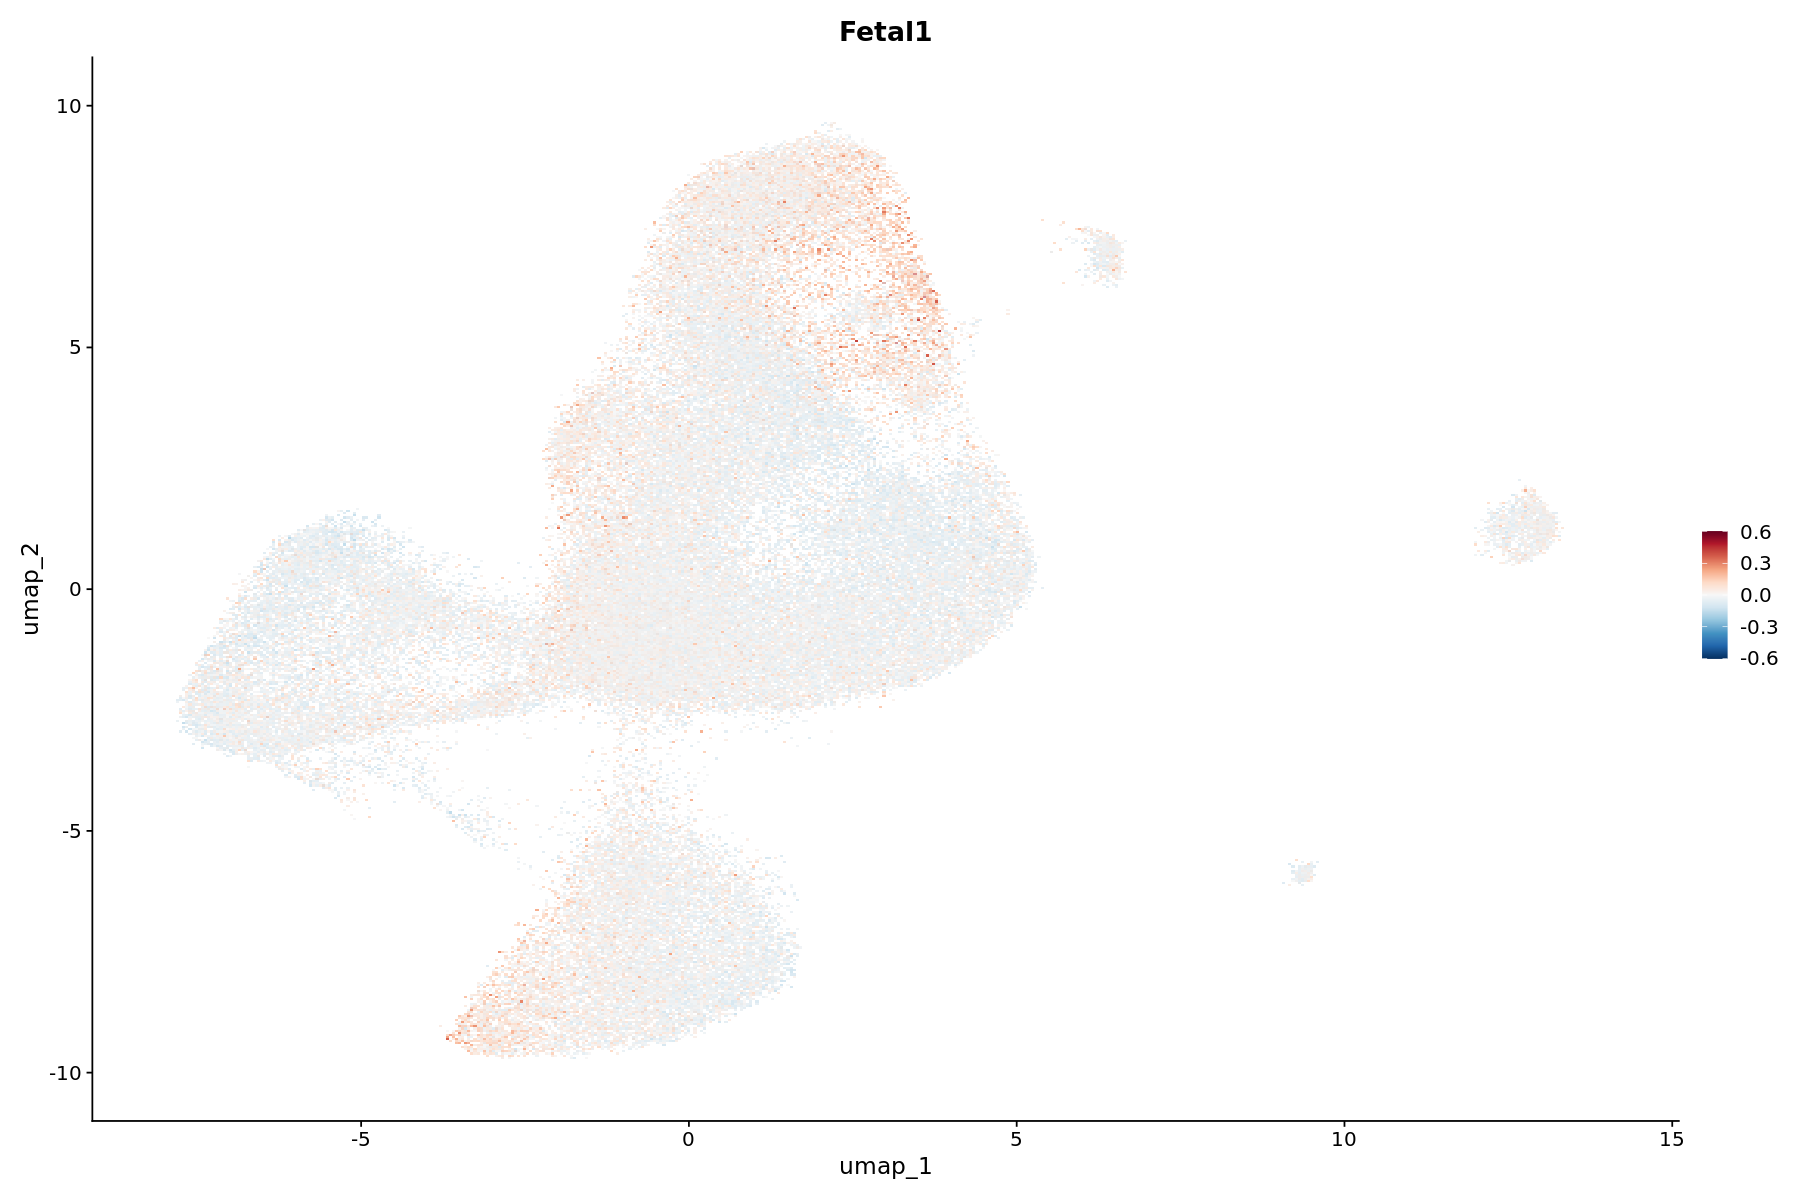

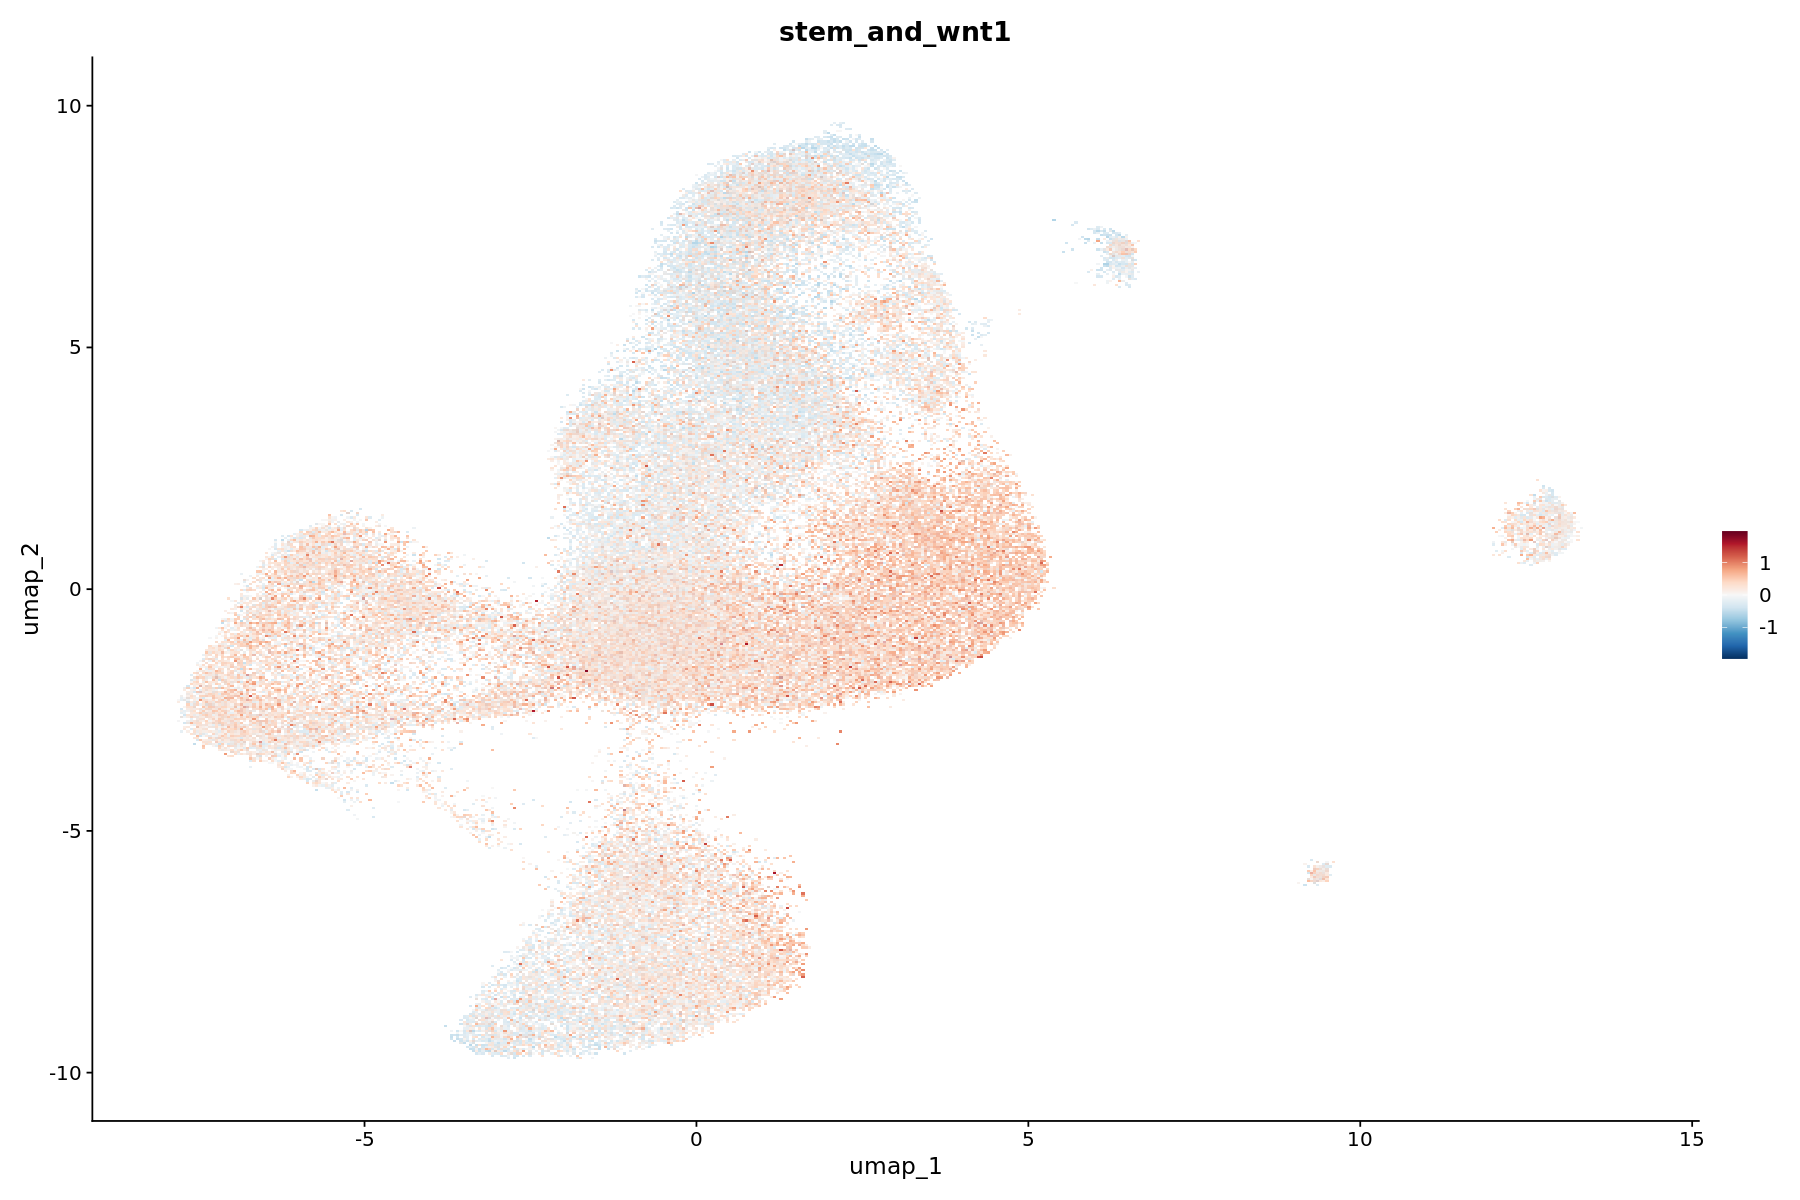

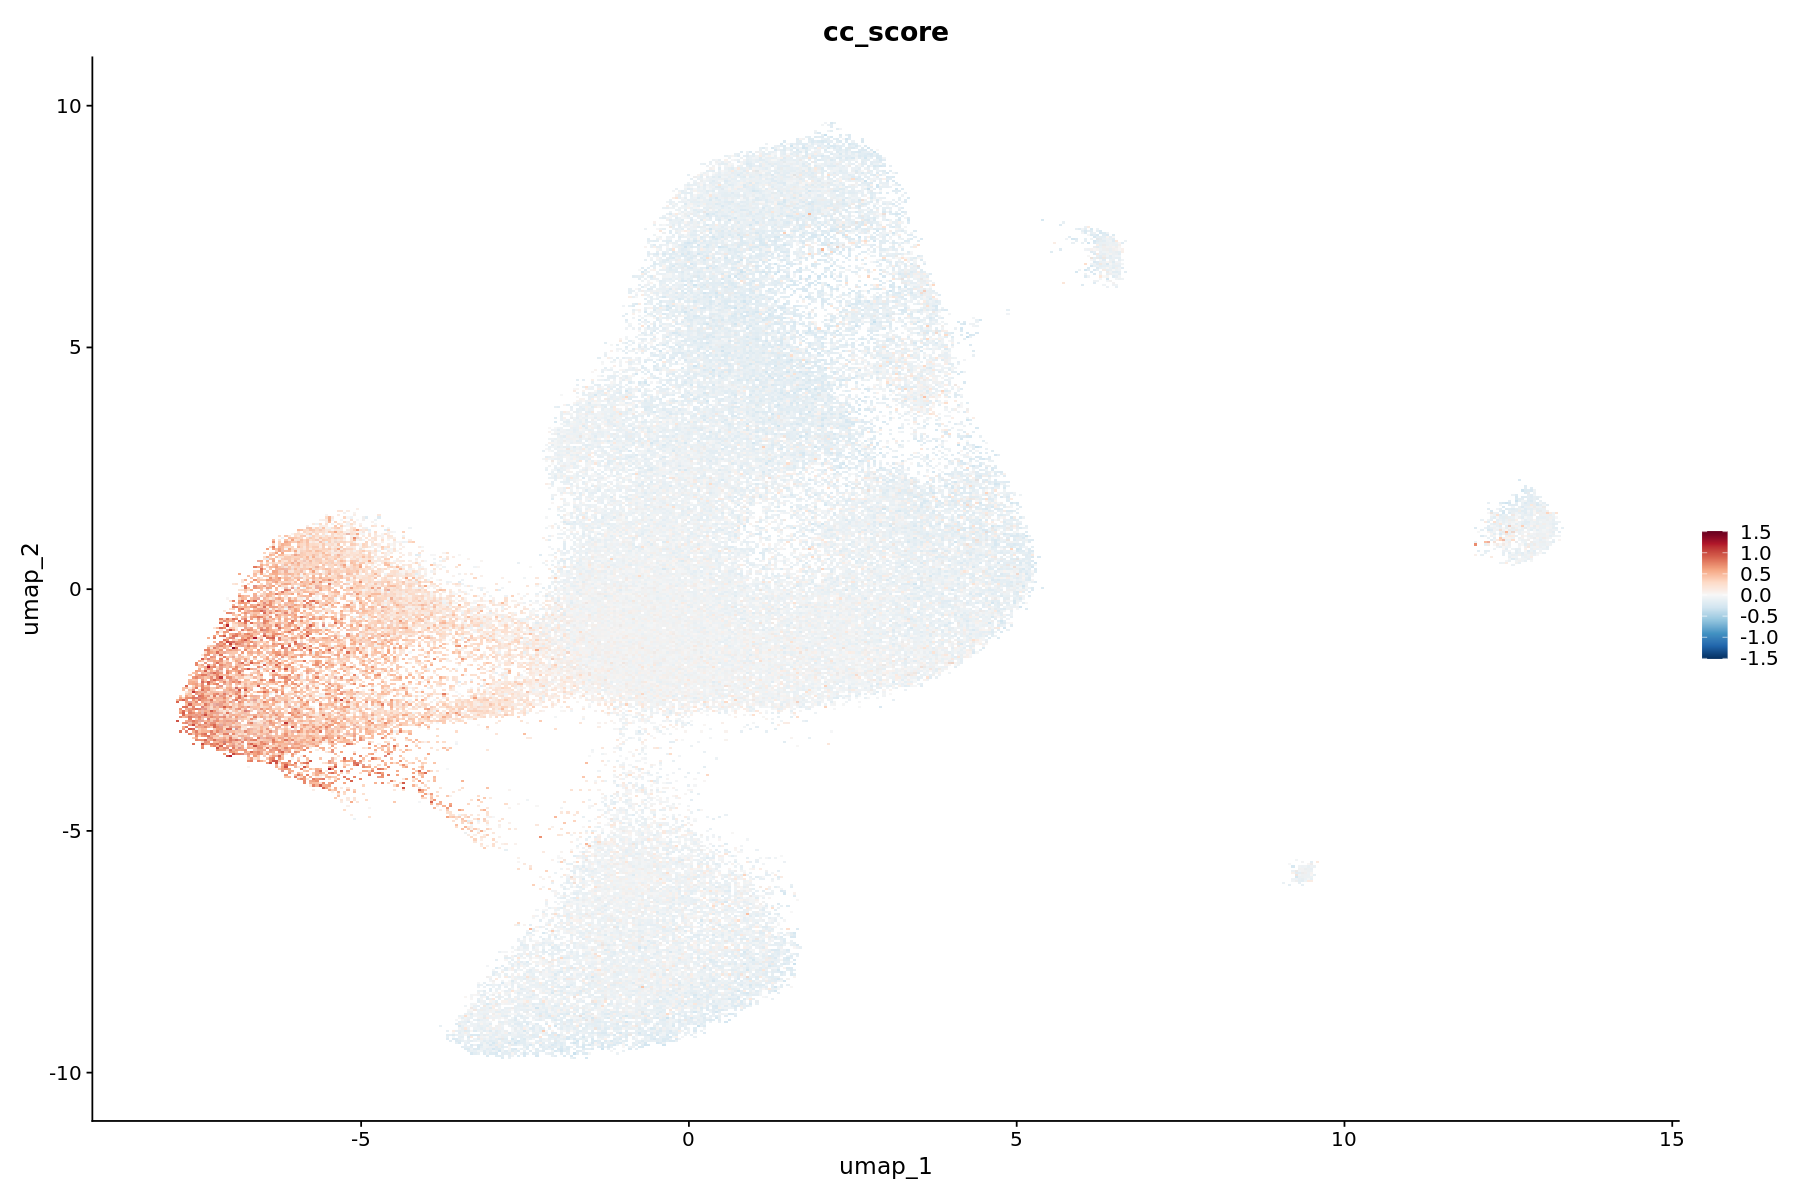

In [99]:
plot_gene_markers(polyp_proj)